In [73]:
import pandas as pd
import pylab as pl
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.metrics import confusion_matrix
%pylab inline

df = pd.read_csv('../data/sample_data.csv', sep=',', header=0, index_col=0)
print df.columns
df.head()

Populating the interactive namespace from numpy and matplotlib
Index([u'site_id', u'strategy_id', u'list_type', u'line_id', u'adv_id',
       u'adv_vertical', u'name', u'goal', u'price', u'limit', u'avg_bid',
       u'max_bid', u'impressions', u'conversions', u'avg_imps_site',
       u'stdev_imps_site', u'win_rate_site', u'win_rate_strat', u'cvr_strat',
       u'cvr', u'line_cvr', u'hist_zscore', u'overlap', u'target_variable',
       u'win_rate_site_table', u'win_rate_strat_table'],
      dtype='object')


,site_id,strategy_id,list_type,line_id,adv_id,adv_vertical,name,goal,price,limit,...,win_rate_site,win_rate_strat,cvr_strat,cvr,line_cvr,hist_zscore,overlap,target_variable,win_rate_site_table,win_rate_strat_table
0,82932,313729,testing,20049,206.0,Travel,Nicole,0.0,3.95,10000.0,...,0.423778,0.111431,0.0,0.001197,0.0,2.708366,0.001066,0,0.450094,0.249479
1,90474,313729,testing,20049,206.0,Travel,Nicole,0.0,3.95,10000.0,...,0.163010,0.111431,0.0,0.001239,0.0,1.188635,0.000703,0,0.158050,0.249479
2,92345,313729,testing,20049,206.0,Travel,Nicole,0.0,3.95,10000.0,...,0.318358,0.111431,0.0,0.000729,0.0,1.503285,0.000873,0,0.360591,0.249479
3,92415,313729,testing,20049,206.0,Travel,Nicole,0.0,3.95,10000.0,...,0.133199,0.111431,0.0,0.005894,0.0,35.153628,0.004614,0,0.113717,0.249479
4,92425,313729,testing,20049,206.0,Travel,Nicole,0.0,3.95,10000.0,...,0.379310,0.111431,0.0,0.000000,0.0,-0.091378,0.000344,0,0.019308,0.249479


#### Define the features of interest

and drop any rows in those feature columns that have any NaN values.  This is important because the MinMaxScaler does not handle NaN

In [74]:
subset=['avg_bid', 'max_bid', 'win_rate_site', 'hist_zscore', 'overlap','win_rate_strat', 'target_variable']
features = subset[:-1]
df = df[subset].dropna(subset=features)

#### Scale features for kNN

In [75]:
min_max_scaler = MinMaxScaler()
knn_scaled = min_max_scaler.fit_transform(df[subset])

df_knn = pd.DataFrame(knn_scaled, columns=subset)

#### Define the test and train set 

Cross-validation is also a great way to define test/train splits

In [79]:
test_idx = np.random.uniform(0, 1, len(df_knn)) <= 0.3
train = df_knn[test_idx==True]
test = df_knn[test_idx==False]
train.head()

,avg_bid,max_bid,win_rate_site,hist_zscore,overlap,win_rate_strat,target_variable
5,0.057692,0.591837,0.312920,0.072092,0.018281,0.089926,0.0
8,0.057692,0.591837,0.023793,0.029022,0.013120,0.089926,0.0
12,0.057692,0.591837,0.324703,0.021840,0.003979,0.089926,0.0
14,0.057692,0.591837,0.110881,0.212855,0.019521,0.089926,0.0
20,0.057692,0.591837,0.305321,0.020175,0.000404,0.089926,0.0


#### Test performance of kNN for different values of k

**When choosing a value of k:**
- never select a k-value that is a multiple of your number of classes
- in this case, since there are two classes, we iterate from k=1 to k=11, odds only
- this is because kNN uses majority voting of the k neighbors.  With k being a multiple of the number of classes, there is a chance for ties.

In [80]:
results = []
num_features = len(features)

for n in range(1, 11, 2):
    clf = KNeighborsClassifier(n_neighbors=n, weights='distance')
    clf.fit(train.ix[:,:num_features], train.ix[:,num_features])
    preds = clf.predict(test.ix[:,:(num_features)])
    accuracy = np.where(preds==test.ix[:,num_features], 1, 0).sum() / float(len(test))
    recall = np.where((preds==test.ix[:,num_features])&(test.ix[:,num_features]==1), 1, 0).sum()/float(np.where(test==1,1,0).sum())
    num_wrong = np.where(preds!=test.ix[:,num_features], 1, 0).sum()
    print "Neighbors: %d, Accuracy: %3f, Recall: %3f, Number wrong: %d, Total positive: %d" % (n, accuracy, recall, num_wrong, len(test))
    print confusion_matrix(test.ix[:,num_features], preds)
    results.append([n, accuracy, recall])

results = pd.DataFrame(results, columns=["n", "accuracy", "recall"])

Neighbors: 1, Accuracy: 0.981878, Recall: 0.191781, Number wrong: 11, Total positive: 607
[[582   2]
 [  9  14]]
Neighbors: 3, Accuracy: 0.981878, Recall: 0.178082, Number wrong: 11, Total positive: 607
[[583   1]
 [ 10  13]]
Neighbors: 5, Accuracy: 0.978583, Recall: 0.150685, Number wrong: 13, Total positive: 607
[[583   1]
 [ 12  11]]
Neighbors: 7, Accuracy: 0.967051, Recall: 0.041096, Number wrong: 20, Total positive: 607
[[584   0]
 [ 20   3]]
Neighbors: 9, Accuracy: 0.963756, Recall: 0.013699, Number wrong: 22, Total positive: 607
[[584   0]
 [ 22   1]]


#### Plot accuracy and recall for each value of k

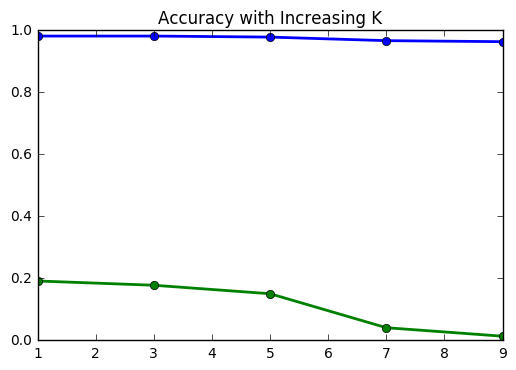

In [81]:
plt.rc("lines", lw=2, marker='o')

pl.plot(results.n, results.accuracy)
pl.plot(results.n, results.recall)
pl.ylim([0,1])
pl.title("Accuracy with Increasing K")
pl.show()

#### Accuracy is good but recall is terrible.  Why?

**kNN is very sensitive to scaling of features.** Some features with the same units (such as $) may be best scaled in relation to the range of all features with those units, not just the range of that feature itself.  Other features may not need to be scaled at all.  For more information, refer here: [About Feature Scaling and Normalization](http://sebastianraschka.com/Articles/2014_about_feature_scaling.html)

**kNN requires all features to be categorical or all continuous.**  If we did want to encode categorical features (such as advertiser_id) in this model with the other continuous features, we might use one-hot encoding or find a distance metric (e.g. Jaccard similarity) that maps advertisers according to the overlap in converters.  

For the second example, you'd have a similarity matrix for all advertisers, and for an incoming feature set with advertiser M, you'd select the vector corresponding to the similarity of all advertisers to advertiser M.  That similarity metric would be used to map the distance from the origin in the direction of advertiser_id.  [More info on StackExchange](http://stackoverflow.com/questions/13625849/knn-classification-with-categorical-data)
